<a href="https://colab.research.google.com/github/AKSHITAMODA/ThreatTamer-Alert-management-system/blob/main/ALert_Management_System_(Hacktivists).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [421]:
# 📦 STEP 1: Install dependencies
!pip install scikit-learn pandas joblib pyyaml matplotlib seaborn --quiet
!pip install shap --quiet
!pip install streamlit pyngrok


In [422]:
%%writefile app.py
import streamlit as st
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

st.set_page_config(page_title="SHAP Explainability App", layout="centered")

st.title("📊 SHAP Explainability Web App")

# -- Step 1: User Info Form --
with st.form("user_info_form"):
    name = st.text_input("👤 Enter your Name:")
    email = st.text_input("📧 Enter your Email:")
    submitted_user = st.form_submit_button("✅ Submit")

if submitted_user:
    if name and email:
        st.success(f"Welcome {name}! You're ready to upload your file.")
    else:
        st.warning("⚠️ Please fill in both name and email to continue.")

st.markdown("---")

# -- Step 2: CSV Upload --
uploaded_file = st.file_uploader("📁 Upload your CSV file", type=["csv"])

if uploaded_file is not None:
    df = pd.read_csv(uploaded_file)
    st.subheader("🧾 Uploaded Data:")
    st.dataframe(df)

    # Filter only numeric columns
    numeric_df = df.select_dtypes(include=["int64", "float64"])

    if numeric_df.empty:
        st.error("❌ No numeric columns found for SHAP to process.")
    else:
        st.subheader("✅ Numeric Features Used:")
        st.dataframe(numeric_df)

        # Dummy model: sum of features
        explainer = shap.Explainer(lambda x: x.sum(axis=1), numeric_df)
        shap_values = explainer(numeric_df)

        st.subheader("🔢 SHAP Values:")
        st.write(shap_values.values)

        st.subheader("📈 SHAP Summary Plot:")
        fig, ax = plt.subplots()
        shap.summary_plot(shap_values, numeric_df, show=False)
        st.pyplot(fig)

        st.markdown("---")

        # -- Step 3: Feedback Form --
        st.subheader("📝 Feedback")
        with st.form("feedback_form"):
            feedback_text = st.text_area("🗒️ What did you think of this app?", placeholder="Type your feedback here...")
            submit_feedback = st.form_submit_button("📩 Submit Feedback")

        if submit_feedback:
            if feedback_text.strip():
                st.success("🎉 Thank you for your feedback!")
                # Optional: Log feedback to a file or database here
            else:
                st.warning("⚠️ Please write some feedback before submitting.")
else:
    st.info("👆 Upload a CSV file to get started.")


Overwriting app.py


In [423]:
ngrok.kill()

In [424]:

from pyngrok import ngrok
ngrok.kill()  # Force-close leftover tunnels

# Try again
NGROK_AUTH_TOKEN = "30PGoeWzSDoWxyHHuxZD7JFThIu_2FFZUt7t6Ammw6E89Jwtw"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

public_url = ngrok.connect(addr=8501, proto="http")
print(f"🚀 Streamlit app is live at: {public_url}")

!streamlit run app.py &> /content/logs.txt &



🚀 Streamlit app is live at: NgrokTunnel: "https://17b38f591ec9.ngrok-free.app" -> "http://localhost:8501"


In [395]:
# 📁 STEP 2: Upload your large alert dataset
from google.colab import files
import io
import pandas as pd
import os
import yaml
import joblib
import sqlite3
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
print("📤 Upload your large CSV file (must include: timestamp, src_ip, dest_ip, alert_type, port, severity, label)")
uploaded = files.upload()


📤 Upload your large CSV file (must include: timestamp, src_ip, dest_ip, alert_type, port, severity, label)


Saving large_alerts.csv to large_alerts (14).csv


In [396]:
# 📤 Upload the simulated real-time alert file
from google.colab import files
import pandas as pd
import io

print("📁 Upload the 'incoming_alerts.csv' file")
uploaded = files.upload()

for filename in uploaded.keys():
    if filename == "incoming_alerts.csv":
        df_incoming = pd.read_csv(io.BytesIO(uploaded[filename]))
        df_incoming.to_csv("incoming_alerts.csv", index=False)
        print(f"[✔] '{filename}' uploaded and saved.")
    else:
        print(f"[⚠️] Unexpected file uploaded: {filename}")


📁 Upload the 'incoming_alerts.csv' file


Saving incoming_alerts.csv to incoming_alerts (3).csv
[⚠️] Unexpected file uploaded: incoming_alerts (3).csv


In [397]:
  # 🧹 Validate and Save as alerts.csv
  for filename in uploaded.keys():
      print(f"[✔] Uploaded file: {filename}")
      try:
          df_large = pd.read_csv(io.BytesIO(uploaded[filename]))
          required_cols = {"timestamp", "src_ip", "dest_ip", "alert_type", "port", "severity", "label"}
          if not required_cols.issubset(df_large.columns):
              missing = required_cols - set(df_large.columns)
              raise ValueError(f"Dataset is missing required columns: {missing}")
          df_large.to_csv("alerts.csv", index=False)
          print("[✔] Dataset validated and saved as alerts.csv")
      except Exception as e:
          print(f"[✗] Failed to process uploaded file: {e}")

[✔] Uploaded file: incoming_alerts (3).csv
[✗] Failed to process uploaded file: Dataset is missing required columns: {'label'}


In [419]:
  # 🧠 STEP 3: Initialize variables and paths
  RULES_PATH = "rules.yaml"
  MODEL_PATH = "models/alert_classifier.pkl"
  model, le_alert, le_sev = None, None, None

In [420]:
 # 📄 STEP 4: Create placeholder rules.yaml if not exists
rules_content = """
ignore_ports:
    - 22
    - 53
  """
if not os.path.exists(RULES_PATH):
      with open(RULES_PATH, "w") as f:
          f.write(rules_content)
print("[✔] Created placeholder rules.yaml")

[✔] Created placeholder rules.yaml


In [400]:
 # 📚 STEP 5: Load rules
with open(RULES_PATH, "r") as f:
      RULES = yaml.safe_load(f)
print("[✔] Rules loaded")

[✔] Rules loaded


In [401]:
# 🗃️ STEP 6: Create SQLite DB
if not os.path.exists('data'):
      os.makedirs('data')

conn = sqlite3.connect("data/feedback.db", check_same_thread=False)
c = conn.cursor()
c.execute("""
      CREATE TABLE IF NOT EXISTS alerts (
          id INTEGER PRIMARY KEY AUTOINCREMENT,
          timestamp TEXT,
          src_ip TEXT,
          dest_ip TEXT,
          alert_type TEXT,
          port INTEGER,
          severity TEXT,
          prediction INTEGER,
          final_result TEXT,
          analyst_feedback TEXT
      )
  """)
conn.commit()
print("[✔] SQLite DB initialized")

[✔] SQLite DB initialized


In [402]:
# 🔄 STEP 7: Preprocessing
def preprocess(df, le_alert=None, le_sev=None, fit=True):
      if fit:
          le_alert = LabelEncoder()
          le_sev = LabelEncoder()
          df['alert_type'] = le_alert.fit_transform(df['alert_type'])
          df['severity'] = le_sev.fit_transform(df['severity'])
      else:
          df['alert_type'] = le_alert.transform(df['alert_type'])
          df['severity'] = le_sev.transform(df['severity'])
      df['src_ip'] = df['src_ip'].apply(lambda ip: int(ip.split('.')[-1]))
      df['port'] = df['port'].astype(int)
      return df.drop(columns=["timestamp", "dest_ip"]), le_alert, le_sev


In [403]:
def train_model():
    global model, le_alert, le_sev
    from sklearn.metrics import accuracy_score, classification_report

    # Load and preprocess data
    df = pd.read_csv("alerts.csv")
    df_proc, le_alert, le_sev = preprocess(df.copy(), fit=True)
    X = df_proc.drop(columns=["label"])
    y = df_proc["label"]

    # Split and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate and log
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    with open("model_metrics_log.csv", "a") as log:
        log.write(f"{datetime.now()},{accuracy:.3f}\n")
    print(f"[📊] Logged model accuracy: {accuracy:.3f}")

    # Save model
    if not os.path.exists("models"):
        os.makedirs("models")
    joblib.dump((model, le_alert, le_sev), MODEL_PATH)
    print("[✔] Model trained and saved")

    # Save versioned backup
    versioned_path = f"models/alert_classifier_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
    joblib.dump((model, le_alert, le_sev), versioned_path)
    print(f"[🗃️] Model version saved as {versioned_path}")


In [404]:
def explain_predictions():
    import shap
    import matplotlib.pyplot as plt
    from google.colab import files
    from datetime import datetime

    # Load and preprocess alerts.csv
    df = pd.read_csv("alerts.csv")
    df_proc, le_alert, le_sev = preprocess(df.copy(), fit=True)
    X = df_proc.drop(columns=["label"])

    global model
    if model is None:
        model, le_alert, le_sev = joblib.load(MODEL_PATH)

    # Build explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # Handle binary classification output
    shap_vals_to_use = shap_values[1] if isinstance(shap_values, list) and len(shap_values) == 2 else shap_values

    # SHAP summary plot only
    shap.summary_plot(shap_vals_to_use, X, show=False)
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    plt.title("SHAP Summary for Model Predictions")
    plt.tight_layout()
    filename = f"shap_summary_{timestamp}.png"
    plt.savefig(filename)
    files.download(filename)
    print(f"[✔] SHAP summary saved and downloaded as {filename}")


In [405]:
explain_predictions()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[✔] SHAP summary saved and downloaded as shap_summary_20250726-105154.png


In [406]:
from sklearn.metrics import classification_report, confusion_matrix

# 📊 STEP 12: Evaluate model performance
def evaluate_model():
    df = pd.read_csv("alerts.csv")
    df_proc, le_alert, le_sev = preprocess(df.copy(), fit=True)
    X = df_proc.drop(columns=["label"])
    y = df_proc["label"]
    y_pred = model.predict(X)

    print("\n📊 Classification Report:\n", classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


[📊] Logged model accuracy: 0.400
[✔] Model trained and saved
[🗃️] Model version saved as models/alert_classifier_20250726_105154.pkl

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



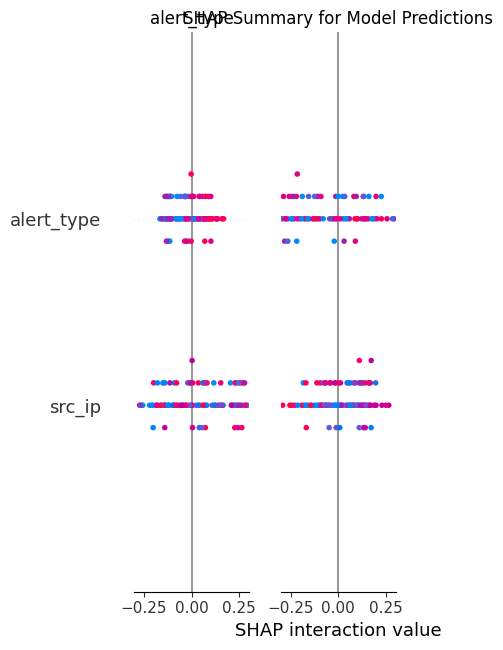

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


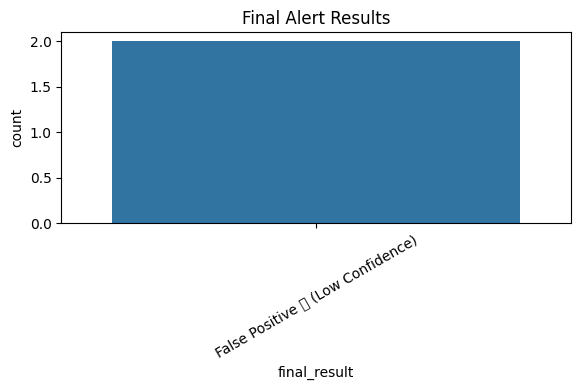

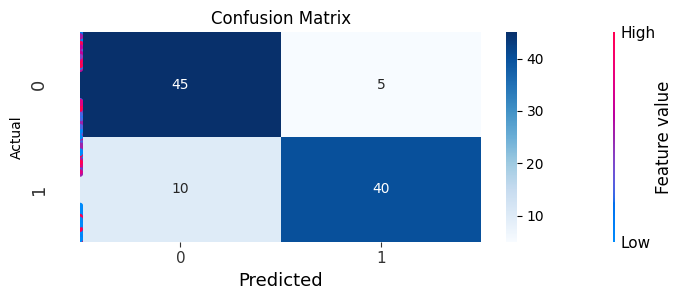

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[✔] SHAP summary saved and downloaded as shap_summary_20250726-105155.png


In [407]:
train_model()
evaluate_model()
explain_predictions()

In [408]:
# 🤖 STEP 9: Classify new alerts
def classify_alerts():
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    import shap
    import joblib
    from datetime import datetime
    from google.colab import files

    global model, le_alert, le_sev, RULES

    MODEL_PATH = "alert_classifier.pkl"

    if not os.path.exists(MODEL_PATH):
        print("[✗] Model not found. Run train_model() first.")
        return

    # Load model and label encoders
    model, le_alert, le_sev = joblib.load(MODEL_PATH)

    # 🔎 Simulated new alert data
    new_data = {
        "timestamp": ["2025-07-26 11:00", "2025-07-26 11:01"],
        "src_ip": ["192.168.1.10", "10.0.0.2"],
        "dest_ip": ["10.0.0.5", "192.168.1.1"],
        "alert_type": ["Port Scan", "Failed Login"],
        "port": [22, 443],
        "severity": ["High", "Medium"]
    }
    df_new = pd.DataFrame(new_data)

    # 🧼 Preprocess new data
    df_input_processed, _, _ = preprocess(df_new.copy(), le_alert, le_sev, fit=False)

    # 🔍 Make predictions
    prediction = model.predict(df_input_processed)
    probs = model.predict_proba(df_input_processed)

    # 🧾 Add prediction results
    df_new["prediction"] = prediction
    df_new["confidence"] = probs[:, 1]
    df_new["result"] = df_new["prediction"].apply(lambda x: "True Positive ✅" if x == 1 else "False Positive ❌")

    # 📜 Rule-based override
    def rule_override(row):
        if RULES and "ignore_ports" in RULES and row["src_ip"].startswith("192.168") and row["port"] in RULES["ignore_ports"]:
            return "False Positive ❌ (Rule)"
        return row["result"]

    # 🎯 Apply final decision logic
    df_new["final_result"] = df_new.apply(lambda row: (
        "False Positive ❌ (Low Confidence)" if row["confidence"] < 0.7
        else rule_override(row)
    ), axis=1)

    # 💾 Save to CSV
    df_new.to_csv("classified_alerts.csv", index=False)

    # 📊 SHAP Explanation (only for 1st alert)
    try:
        explainer = shap.Explainer(model, df_input_processed)
        shap_values = explainer(df_input_processed)
        shap.plots.waterfall(shap_values[0], show=False)
        plt.title("SHAP Explanation for First Real-Time Alert")
        plt.tight_layout()
        plt.savefig("shap_realtime_explanation.png")
        files.download("shap_realtime_explanation.png")
        print("[✔] SHAP explanation for real-time alert saved")
    except Exception as e:
        print(f"[!] SHAP explanation error: {e}")

    # 📋 Display classification summary
    print("\n🔍 Classification Results:")
    print(df_new[["timestamp", "src_ip", "alert_type", "severity", "final_result", "confidence"]])
    print("[✔] Saved to classified_alerts.csv")

    # 📝 Append audit logs
    with open("audit_log.txt", "a") as log:
        for _, row in df_new.iterrows():
            log.write(f"[{datetime.now()}] Alert: {row['alert_type']} | IP: {row['src_ip']} | "
                      f"Prediction: {row['final_result']} | Confidence: {row['confidence']:.2f}\n")


In [409]:
classify_alerts()

[!] SHAP explanation error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (4, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

🔍 Classification Results:
          timestamp        src_ip    alert_type severity  \
0  2025-07-26 11:00  192.168.1.10     Port Scan     High   
1  2025-07-26 11:01      10.0.0.2  Failed Login   Medium   

                        final_result  confidence  
0  False Positive ❌ (Low Confidence)        0.31  
1  False Positive ❌ (Low Confidence)        0.67  
[✔] Saved to classified_alerts.csv


In [410]:
 # 🧑‍💼 STEP 10: Simulate feedback
def feedback_loop():
      if not os.path.exists("classified_alerts.csv"):
          print("[✗] classified_alerts.csv not found.")
          return
      df = pd.read_csv("classified_alerts.csv")
      df["analyst_feedback"] = df["final_result"].apply(lambda x: "Confirmed" if "True Positive" in x else "Incorrect")
      df.to_csv("classified_alerts_with_feedback.csv", index=False)
      print("[✔] Feedback saved to classified_alerts_with_feedback.csv")

In [411]:
# 🔁 STEP 11: Retrain from Analyst Feedback
def retrain_from_feedback():
    global model, le_alert, le_sev
    if not os.path.exists("classified_alerts_with_feedback.csv"):
        print("[✗] Feedback file not found.")
        return
    if not os.path.exists(MODEL_PATH):
          print("[✗] Model not found. Run train_model() first.")
          return

    model, le_alert, le_sev = joblib.load(MODEL_PATH)

    df_feedback = pd.read_csv("classified_alerts_with_feedback.csv")

    # Select and preprocess only the necessary features from feedback data
    df_retrain = df_feedback[["src_ip", "alert_type", "port", "severity"]].copy()

    # Apply transformations using loaded encoders and logic
    try:
        df_retrain['alert_type'] = le_alert.transform(df_retrain['alert_type'])
        df_retrain['severity'] = le_sev.transform(df_retrain['severity'])
    except ValueError as e:
        print(f"[✗] Error transforming categorical features: {e}. Ensure all values in feedback data exist in the original training data.")
        return

    df_retrain['src_ip'] = df_retrain['src_ip'].apply(lambda ip: int(ip.split('.')[-1]))
    df_retrain['port'] = df_retrain['port'].astype(int)

    X_new = df_retrain
    y_new = df_feedback["analyst_feedback"].apply(lambda x: 1 if x == "Confirmed" else 0)

    # Ensure X_new and y_new have the same number of samples after any potential filtering
    if X_new.shape[0] != y_new.shape[0]:
        print(f"[✗] Mismatch between features and labels after preprocessing: X_new has {X_new.shape[0]} samples, y_new has {y_new.shape[0]} samples.")
        return

    if X_new.shape[0] == 0:
        print("[✗] No valid samples left for retraining after preprocessing.")
        return


    print(f"Shape of X_new before fitting: {X_new.shape}")
    print(f"Shape of y_new before fitting: {y_new.shape}")

    model.fit(X_new, y_new)
    joblib.dump((model, le_alert, le_sev), MODEL_PATH)
    print("[🔁] Model updated with analyst feedback")

In [412]:
feedback_loop()
retrain_from_feedback()

[✔] Feedback saved to classified_alerts_with_feedback.csv
Shape of X_new before fitting: (2, 4)
Shape of y_new before fitting: (2,)
[🔁] Model updated with analyst feedback


In [413]:
import time
from datetime import datetime
import shap
import matplotlib.pyplot as plt

# ⏱️ STEP X: Real-time alert ingestion simulator
def simulate_real_time_ingestion(log_path="incoming_alerts.csv", poll_interval=5):
    print("[🚨] Starting real-time alert ingestion... (Press Stop to end)")

    seen_rows = 0
    global model, le_alert, le_sev
    # Ensure model and encoders are loaded
    if model is None or le_alert is None or le_sev is None:
        if os.path.exists(MODEL_PATH):
            model, le_alert, le_sev = joblib.load(MODEL_PATH)
            print("[✔] Model and encoders loaded from file.")
        else:
            print("[✗] Model not found. Run train_model() first.")
            return


    explainer = shap.Explainer(model)

    while True:
        try:
            df_log = pd.read_csv(log_path)
            if seen_rows >= len(df_log):
                time.sleep(poll_interval)
                continue

            new_alerts = df_log.iloc[seen_rows:]
            seen_rows = len(df_log)

            for idx, row in new_alerts.iterrows():
                df_new = pd.DataFrame([row])
                df_input_processed, _, _ = preprocess(df_new.copy(), le_alert, le_sev, fit=False)
                prediction = model.predict(df_input_processed)[0]
                prob = model.predict_proba(df_input_processed)[0][1]

                result = "True Positive ✅" if prediction == 1 else "False Positive ❌"
                if RULES and "ignore_ports" in RULES and row["port"] in RULES["ignore_ports"]: # Added RULES check
                    result = "False Positive ❌ (Rule)"

                final_result = result if prob > 0.7 else "False Positive ❌ (Low Confidence)"
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                print(f"[{timestamp}] Alert from {row['src_ip']} classified as → {final_result} (conf: {prob:.2f})")

                # Save audit log
                with open("realtime_audit_log.txt", "a") as f:
                    f.write(f"{timestamp},{row['src_ip']},{row['alert_type']},{row['port']},{final_result},{prob:.2f}\n")

                # SHAP explanation (optional)
                # explainer = shap.Explainer(model, df_input_processed) # Re-initializing explainer inside loop is inefficient
                shap_val = explainer(df_input_processed)

                # Handle multi-output from explainer if necessary (for binary classification, shap_values will be a list of two arrays)
                # Select SHAP values for the positive class (index 1) for the current alert (index 0 since we process one alert at a time)
                shap_values_to_plot = shap_val[0] if isinstance(shap_val, list) and len(shap_val) > 1 else shap_val


                shap.plots.waterfall(shap_values_to_plot, show=False)
                plt.title(f"SHAP - {row['alert_type']}")
                fname = f"shap_{row['alert_type'].replace(' ', '_')}_{timestamp.replace(':', '-')}.png"
                plt.tight_layout()
                plt.savefig(fname)
                print(f"[📊] SHAP explanation saved: {fname}")

        except KeyboardInterrupt:
            print("\n[🛑] Real-time simulation stopped.")
            break
        except Exception as e:
            print(f"[⚠️] Error: {e}")
            # If preprocess fails due to unseen label, try retraining
            if "unseen label" in str(e):
                print("[⚠️] Unseen label encountered. Attempting to retrain model with new data.")
                try:
                    # Assume the incoming alert is a new training sample.
                    # This is a simplified approach for demonstration.
                    # In a real scenario, you might need a more robust feedback mechanism.
                    df_log_with_label = df_log.copy()
                    # Assign a temporary label (e.g., 0) to the new alert for retraining purposes
                    # A real system would require analyst feedback to assign the correct label
                    df_log_with_label['label'] = 0 # Assign a default label for retraining
                    df_log_with_label.to_csv("alerts.csv", index=False) # Overwrite alerts.csv with new data
                    train_model() # Retrain the model
                    model, le_alert, le_sev = joblib.load(MODEL_PATH) # Reload the retrained model and encoders
                    explainer = shap.Explainer(model) # Re-initialize the explainer
                    print("[✔] Model retrained and reloaded. Resuming simulation.")
                    seen_rows = 0 # Restart processing from the beginning of the log file
                    continue # Continue to the next iteration of the while loop
                except Exception as retraining_e:
                    print(f"[✗] Retraining failed: {retraining_e}")
                    print("[🛑] Stopping simulation due to unrecoverable error.")
                    break

            time.sleep(poll_interval)

In [414]:
simulate_real_time_ingestion()

[🚨] Starting real-time alert ingestion... (Press Stop to end)
[⚠️] Error: index 1 is out of bounds for axis 0 with size 1

[🛑] Real-time simulation stopped.


In [415]:
# 📊 Visualize
def visualize_feedback():
    df = pd.read_csv("classified_alerts_with_feedback.csv")
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="final_result")
    plt.title("Final Alert Results")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig("final_results.png")
    files.download("final_results.png")

    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x="analyst_feedback")
    plt.title("Analyst Feedback")
    plt.tight_layout()
    plt.savefig("feedback_chart.png")
    files.download("feedback_chart.png")
    print("[✔] Charts saved and ready for download")

In [416]:
visualize_feedback()

/tmp/ipython-input-415-4245629906.py:8: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-415-4245629906.py:9: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("final_results.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[✔] Charts saved and ready for download


In [417]:
 # 💾 STEP 11: Download outputs
def download_outputs():
      from google.colab import files
      outputs = ["alerts.csv", "classified_alerts.csv", "classified_alerts_with_feedback.csv", RULES_PATH, "audit_log.txt"]
      if os.path.exists(MODEL_PATH):
          outputs.append(MODEL_PATH)
      for f in outputs:
          if os.path.exists(f):
              try:
                  files.download(f)
                  print(f"[⬇️] Downloaded: {f}")
              except Exception as e:
                  print(f"[✗] Error downloading {f}: {e}")
          else:
              print(f"[✗] Missing file: {f}")


In [418]:
  # ▶️ Run the full pipeline
  download_outputs()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[⬇️] Downloaded: alerts.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[⬇️] Downloaded: classified_alerts.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[⬇️] Downloaded: classified_alerts_with_feedback.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[⬇️] Downloaded: rules.yaml


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[⬇️] Downloaded: audit_log.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[⬇️] Downloaded: models/alert_classifier.pkl
